In [130]:
import matplotlib.pyplot as pl
import sbi
import numpy as np
import torch
import getdist
from getdist import plots, MCSamples

from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

import pdb
import time

%matplotlib inline

In [131]:
# Set up true posterior.  We'll use a 3D Gaussian.
theta_true = np.array([0.3, 0.5, 0.7])
cov = np.array([[0.01, 0.0, 0.0], [0.0, 0.01, 0.0], [0.0, 0.0, 0.01]])
num_dim = len(theta_true)

# Generate some data from the true posterior.
data = np.random.multivariate_normal(theta_true, cov)

# Draw samples from the true posterior.
# since we assume wide flat priors, the posterior is just the likelihood conditioned on the data.
posterior_samples_true = np.random.multivariate_normal(data, cov, size=10000)

# Define the prior.
prior = sbi.utils.torchutils.BoxUniform(low=-10.*torch.ones(num_dim), high=10.*torch.ones(num_dim))

# Define the simulator.
def simulator(theta):
    dims = theta.shape
    if len(dims) == 1:
        return np.random.multivariate_normal(theta, cov)
    else:
        #return np.array([np.random.multivariate_normal(theta[i], cov) for i in range(dims[0])])
        #mean zero
        #temp = torch.randn(dims)
        #t = torch.from_numpy(a)
        #return np.array([np.random.multivariate_normal(theta[i], cov) for i in range(dims[0])])
        #THIS IS KINDA FUNKY
        return np.random.multivariate_normal(theta[0], cov)

In [142]:
#SNPE
t1 = time.time()
posterior_snpe_amortized = infer(simulator, prior, num_simulations=50000, method='SNPE')
t2 = time.time()
print("time taken = ", t2-t1)

Running 50000 simulations.: 100%|██████████| 50000/50000 [00:08<00:00, 5704.75it/s]


 Training neural network. Epochs trained: 10

KeyboardInterrupt: 

In [134]:
#SNLE
t1 = time.time()
posterior_snle = infer(simulator, prior, num_simulations=1000, method='SNLE')
t2 = time.time()
print("time taken = ", t2-t1)

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:00<00:00, 4299.75it/s]


 Neural network successfully converged after 223 epochs.time taken =  39.17534017562866


In [135]:
#SNRE
t1 = time.time()
posterior_snre = infer(simulator, prior, num_simulations=1000, method='SNRE')
t2 = time.time()
print("time taken = ", t2-t1)

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:00<00:00, 5473.12it/s]


 Neural network successfully converged after 79 epochs.time taken =  7.532166957855225


In [103]:
# Multiround inference with SNPE
simulator_sbi, prior_sbi = prepare_for_sbi(simulator, prior)
inference_snpe = SNPE(prior = prior)

t1 = time.time()
num_rounds = 3
proposal = prior_sbi
posteriors = []
for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator_sbi, proposal, num_simulations=1000)
    density_estimator = inference_snpe.append_simulations(theta, x, proposal = proposal).train()
    posterior_snpe_multiround = inference_snpe.build_posterior(density_estimator)
    posteriors.append(posterior_snpe_multiround)
    proposal = posterior_snpe_multiround.set_default_x(data)
t2 = time.time()
print("time taken = ", t2-t1)

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:00<00:00, 3427.77it/s]


 Neural network successfully converged after 219 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:00<00:00, 4702.56it/s]


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 87

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 88 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:00<00:00, 3902.27it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 33 epochs.time taken =  126.41515398025513


In [140]:
#Generate samples

samples_snpe_amortized = posterior_snpe_amortized.sample((10000,), x=data)

#samples_snpe_multiround = posterior_snpe_multiround.sample((10000,), x=data)
#samples_snpe_multiround = posteriors[0].sample((10000,), x=data)

#samples_snre = posterior_snre.sample((10000,), x=data)

#SNLE has to run an MCMC to get samples - takes a while
#samples_snle = posterior_snle.sample((1000,), x=data)

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 59897.49it/s]


Removed no burn in
Removed no burn in


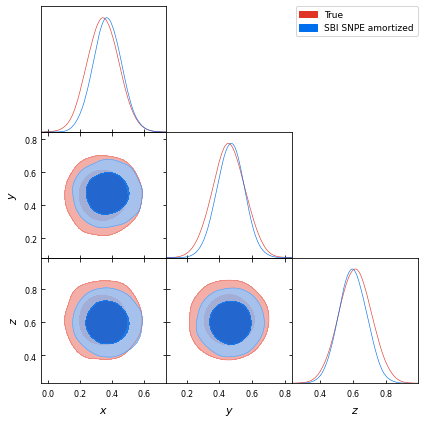

In [141]:
#Make getdist plots

gd_snpe_amortized = MCSamples(samples = samples_snpe_amortized.numpy(), names = ['x', 'y', 'z'], labels = ['x', 'y', 'z'], label = 'SBI SNPE amortized')
#gd_snpe_multiround = MCSamples(samples = samples_snpe_multiround.numpy(), names = ['x', 'y', 'z'], labels = ['x', 'y', 'z'], label = 'SBI SNPE multiround')
#gd_snle  = MCSamples(samples = samples_snle.numpy(), names = ['x', 'y', 'z'], labels = ['x', 'y', 'z'], label = 'SBI SNLE')
gd_true = MCSamples(samples = posterior_samples_true, names = ['x', 'y', 'z'], labels = ['x', 'y', 'z'], label = 'True')
g = plots.get_subplot_plotter()
g.triangle_plot([gd_true, gd_snpe_amortized], filled=True)


In [110]:

import torch

from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis

_ = torch.manual_seed(0)

In [111]:
num_dim = 3
prior = utils.BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))

In [112]:
def linear_gaussian(theta):
    return theta + 1.0 + torch.randn_like(theta) * 0.1

In [113]:
simulator, prior = prepare_for_sbi(linear_gaussian, prior)


In [114]:
inference = SNPE(prior=prior)


In [120]:
num_rounds = 3
x_o = torch.zeros(
    3,
)

posteriors = []
proposal = prior

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=500)
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

Running 500 simulations.: 100%|██████████| 500/500 [00:00<00:00, 34492.06it/s]


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 24

Running 500 simulations.: 100%|██████████| 500/500 [00:00<00:00, 34806.92it/s]

 Neural network successfully converged after 25 epochs.Using SNPE-C with atomic loss


 Training neural network. Epochs trained: 32

Running 500 simulations.: 100%|██████████| 500/500 [00:00<00:00, 33301.87it/s]

 Neural network successfully converged after 33 epochs.Using SNPE-C with atomic loss


 Neural network successfully converged after 26 epochs.

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 54963.15it/s]


Removed no burn in
Removed no burn in
Removed no burn in


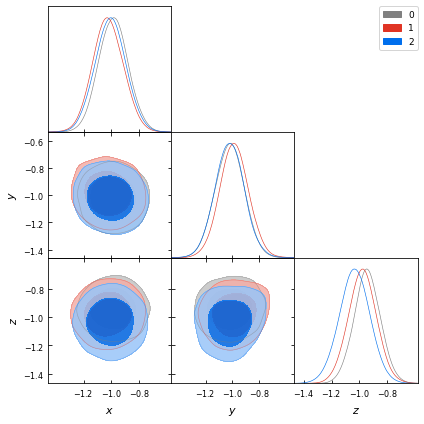

In [122]:
posterior_samples0 = posteriors[0].sample((10000,), x=x_o)
posterior_samples1 = posteriors[1].sample((10000,), x=x_o)
posterior_samples2 = posteriors[2].sample((10000,), x=x_o)

gd0 = MCSamples(samples = posterior_samples0.numpy(), names = ['x', 'y', 'z'], labels = ['x', 'y', 'z'], label = '0')
gd1 = MCSamples(samples = posterior_samples1.numpy(), names = ['x', 'y', 'z'], labels = ['x', 'y', 'z'], label = '1')
gd2 = MCSamples(samples = posterior_samples2.numpy(), names = ['x', 'y', 'z'], labels = ['x', 'y', 'z'], label = '2')
g = plots.get_subplot_plotter()
g.triangle_plot([gd0, gd1, gd2], filled=True)
